Dask Approach to Non-SQL PTM Queries
--

v01: move away from classes, try to organize the computation 
primarily in dask.

In [1]:
# There are some issues with memory usage. It seems
# (mostly based on github discussions) that with dask
# shuttling many large memory allocations around, memory
# gets fragmented and effectively lost. print_rusage()
# will report current memory usage, and the code in the
# next block changes malloc behavior to reduce 
# fragmentation.

import gc
import psutil
from distributed.utils import format_bytes
proc = psutil.Process()

def print_rusage():
    gc.collect()
    print(format_bytes(proc.memory_info().rss))
    #ru=resource.getrusage(resource.RUSAGE_SELF)
    #print(f"{ru.ru_maxrss/1000/1000.:.3f} GB maxrss")
    # That's saying that this process is using 55GB of RAM!?
    
print_rusage() # Starts 80MB

75.05 MB


In [2]:
import postproc_dask as post
import six
six.moves.reload_module(post)
post.config_malloc()

In [3]:
try:
    client.close()
except NameError:
    pass

In [4]:
import multiprocessing.popen_spawn_posix #  https://github.com/dask/distributed/issues/4168
import dask
import dask.dataframe as dd
import dask.bag as db

from dask.distributed import Client
client=Client(n_workers=16,threads_per_worker=1)
client.cluster

/opt/anaconda3/envs/general/lib/python3.9/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43271 instead
  warnings.warn(


In [5]:
import matplotlib.pyplot as plt
import conc_figure
import six
import stompy.plot.cmap as scmap
from stompy.spatial import proj_utils
from matplotlib import cm
cmap=cm.CMRmap_r
cmap=scmap.cmap_clip(cmap,0.03,1.0)

%matplotlib notebook

In [6]:
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import re

from stompy.grid import unstructured_grid
from stompy import utils, memoize
from stompy.model.fish_ptm import ptm_config, ptm_tools
from stompy.model.suntans import sun_driver
from scipy.stats import spearmanr

import stompy.plot.cmap as scmap
from scipy import stats
import seaborn as sns
turbo=scmap.load_gradient('turbo.cpt')

Overall Process
===

1. SUNTANS hydro runs
2. SUNTANS average output
3. ptm-formatted average output
4. PTM runs
5. Load data

The top-level query is something like *generate a map of concentrations for...*

filter on:
 - sources $x$
 - settling classes $y$
 - vertical positions $z$
 - horizontal positions $h$

weighted by

 - loading data 
 - age
 
mapped by one of ...

 - bounding box
 - put on hydro grid
 - put on regular grid

and possibly smoothed.

In [7]:
# Experiment level configuration -- small, all python native data.
cfg=dict(
    ptm_base_dir="/opt2/sfb_ocean/ptm/all_source_022b",
    sun_base_dir="/opt2/sfb_ocean/suntans/runs",
    ptm_output_interval=np.timedelta64(1,'h')
)
cfg['ptm_run_patt']=os.path.join(cfg['ptm_base_dir'],"chunk??","20??????")
cfg['sun_patt']=os.path.join(cfg['sun_base_dir'],"merged_022_20??????")

ptm_run_paths=glob.glob(cfg['ptm_run_patt'])
ptm_run_paths.sort()
cfg['ptm_run_paths']=ptm_run_paths

sun_paths=glob.glob(cfg['sun_patt'])
sun_paths.sort()
cfg['sun_paths']=sun_paths

In [8]:
# Load the grid into... grid
hydro_path=sun_paths[0]
ptm_ds=xr.open_dataset(os.path.join(hydro_path,"ptm_average.nc_0000.nc"))
grid=unstructured_grid.UnstructuredGrid.read_ugrid(ptm_ds,dialect='fishptm')
ptm_ds.close()   

# distribute to workers ahead of time.
grid_d=client.scatter(grid)
cfg['grid_d']=grid_d # too far?

In [9]:
# So far this is only used locally.  Slow to compute (15s)
Msmooth=grid.smooth_matrix()
Msmooth_K=grid.smooth_matrix(K=100*np.ones(grid.Nedges()))

INFO:utils:59574/99089
INFO:utils:59809/99089


In [10]:
# Or could make this delayed and have it execute on each client?
load_data_d=client.scatter(post.get_load_data())
cfg['load_data_d']=load_data_d


In [11]:
def total_area(g):
    return g.cells_area().sum()

total_area_d=dask.delayed(total_area)(grid_d)
cfg['total_area_d']=total_area_d


In [12]:
# Hydro timestamps
cfg['hydro_timestamps']=post.load_hydro_timestamps(sun_paths)


In [13]:
bc_ds_d=client.scatter(post.bc_ds(cfg=cfg))
cfg['bc_ds_d']=bc_ds_d

In [14]:
%%time
if 0:
    # This takes 40s or so.
    criteria=dict(t_min=np.datetime64("2017-06-30 00:00"), # should be 08/30
                  t_max=np.datetime64("2017-07-01 00:00"), # should be 09/14
                  category='nonfiber',
                  z_below_surface_max=0.095,
                  age_max=np.timedelta64(10,'D'))
if 0:
    # For 2 days, takes 2m17
    # Had to dial down the size.  With partition size of 30MB
    # this takes 50 minutes.
    # With a 150MB partition size, and some prefiltering based on age_max,
    # This is down to 13m42.
    criteria=dict(t_min=np.datetime64("2017-08-30 00:00"), 
                  t_max=np.datetime64("2017-09-14 00:00"), 
                  category='nonfiber',
                  z_below_surface_max=0.095,
                  age_max=np.timedelta64(10,'D'))

    conc_ds=post.query_particle_concentration(criteria=criteria,cfg=cfg,
                                              grid=grid,decay=None)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


In [ ]:
six.moves.reload_module(conc_figure)

conc_figure.BayConcFigure(conc_ds,grid=grid,cmap=cmap)

Next steps
--


1. Recreate some of the figures from before, including on-grid smoothing.  
  a. Sample plot: from the powerpoint. 2017-08-30 to 2017-09-14. Surface particles
     max age of 10 days.   *This plot is similarish -- not exactly the same but close
     enough to rule out fundamental errors*
2. Pull out manta samples as before. Maybe skip putting it on the grid, just
   query a radius.
  a. Implement in this notebook
  b. Move all of this to a module.

In [15]:
areas=grid.cells_area()
six.moves.reload_module(post)
    

<module 'postproc_dask' from '/home/rusty/src/microplastic_sfbay/postprocess/postproc_dask.py'>

In [ ]:
#  Bring in the manta code, and extract samples
#   - Start with doing it similar to how 

In [16]:
ll2utm=proj_utils.mapper('WGS84','EPSG:26910')
# Load the manta data, clean it up
manta_fn='manta_summary-v03.csv'
manta=pd.read_csv(manta_fn)
manta.head()

,SampleID,SAMPLE LOCATION,DATE,TYPE,LAT START,LONG START,LAT END,LONG END,TOTAL DIST (M),START FLOW,...,part_per_m3_std,part_per_m2_std,part_per_m3_raw_std,part_per_m2_raw_std,part_per_m3_nofiber,part_per_m2_nofiber,part_per_m3_raw_nofiber,part_per_m2_raw_nofiber,x,y
0,CB-4-Manta-21Aug2017,CB4,2017-08-21 00:00:00,Manta,37.915567,-122.441217,37.941933,-122.419983,3473.323262,NaN,...,0.224191,0.021298,0.442172,0.042006,0.015526,0.001475,0.024841,0.002360,550040.331073,4.198063e+06
1,SPB3-Manta-21Aug2017,SPB3,2017-08-21 00:00:00,Manta,38.023072,-122.371583,38.042133,-122.321883,66678.222270,9113.0,...,1.817781,0.172689,1.928407,0.183199,0.296678,0.028184,0.301706,0.028662,557329.971756,4.209634e+06
2,SUB1-Manta-21Aug2017,SUB1,2017-08-21 00:00:00,Manta,38.107067,-122.056283,38.096533,-122.064917,1393.740434,128369.0,...,NaN,NaN,0.000000,0.000000,0.032671,0.003104,0.039205,0.003724,582363.556136,4.217527e+06
3,SPB2-Manta-21Aug2017,SPB2,2017-08-21 00:00:00,Manta,38.051283,-122.421750,38.023000,-122.428117,3194.008847,220135.0,...,0.210549,0.020002,0.402882,0.038274,0.021966,0.002087,0.034288,0.003257,550464.046320,4.210092e+06
4,CB9-Manta-22Aug2017,CB9,2017-08-22 00:00:00,Manta,37.687233,-122.290917,37.698500,-122.298433,1416.656380,290000.0,...,0.085947,0.008165,0.174186,0.016548,0.085947,0.008165,0.091677,0.008709,562183.425087,4.171973e+06


In [17]:
# build a godin window
from stompy import filters
godwin_offset_h=50
imp=np.arange(100)==godwin_offset_h-1 # seems my godin filter is shifted 1
godwin=filters.lowpass_godin(imp,mean_dt_h=1.0)
assert godwin_offset_h==np.argmax(godwin)
# godwin[delta_hours + h_offset] gives the weight for the time average
# of a sample taken delta_hours away from t_center

In [67]:
cfg['manta_out_dir']="manta_sets_20210317a"
six.moves.reload_module(post)

# now the 021b runs.
# c suffix: use tighter -0.095 z filter.
# 20200227: start of v03
# 20200302: start of v04
# 20200305: try larger window -- extra 24 hours in both directions.
# 20200312: new sources in ptm data, with v02 stormwater concs.
# 20200330: more new sources.
# 20210210a: dask code, new hydro, new ptm. new year.
# 20210317a: new ptm runs with no SJ loss...
os.makedirs(cfg['manta_out_dir'],exist_ok=True)

last_DATE=None
df=None

for idx,rec in manta.iterrows():
    print(idx)
    # since we're just pulling out whole days, cache by day.
    # and pull through the end of that day
    # 5s, all in read_parquet
    if rec.DATE==last_DATE:
        pass
    else:
        df=post.particles_for_date(rec.DATE,cfg=cfg)
        last_DATE=rec.DATE
    
    # Trawl-specific processing:
    # Pull subset of cells
    # add a cell weighting, and a time weighting for the tidal filter
    tfn=os.path.join(cfg['manta_out_dir'],f"v01-manta_{idx}.parquet")
    
    # Fast
    cells,weights=post.rec_to_cell_weights(rec,areas=areas,grid=grid,
                                           Msmooth=Msmooth,smooth=30,thresh=1e-5)
    # Fast
    df_spatial=pd.DataFrame(dict(cell=cells,weight_spatial=weights)).set_index('cell')
    # 1.3s. selecting a subset of rows, and adding a column with spatial weight.
    # Using a dictionary might get this down to 60% of original
    # going through numpy  might get down to 40% of original. 
    tdf=df.join(df_spatial,on='cell',how='inner')
    # Now tdf has only particles from the neighborhood, with a spatial
    # weight per particle.
    
    t_sample=np.datetime64(rec['DATE'])    
    t_center = t_sample+np.timedelta64(8,'h') + np.timedelta64(12,'h')
    delta_hours=((tdf['time']-t_center)/np.timedelta64(1,'h')).astype(np.int32)
    tdf['weight_time']=godwin[delta_hours+godwin_offset_h]
    #tdf.to_parquet(tfn)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64


In [68]:
def group_weights(tdf,storm_factor=1.0):
    groups=tdf['group'].unique()
    group_to_weight={}
    for grp in groups:
        for potw in ['sunnyvale','san_jose','palo_alto','cccsd',
                     'fs','src000','src001','src002']:
            if ('/'+potw) in grp:
                group_to_weight[grp]=1.0
                break
        else:
            group_to_weight[grp]=storm_factor
    weights=tdf['group'].map(group_to_weight)
    return weights

In [70]:
# Compile the model predictions into a new dataframe
# with index matching manta

# Decay time scale
# tau=np.inf # 0.078, 0.586
# tau=20D    # 0.055, 0.665
# tau=10D    # 0.042, 0.689
# tau=5D     # 0.029, 0.702
# tau=2D     # 0.012, 0.730
# tau=1D     # -0     0.74
# tau=np.timedelta64(60,'D')

def predict_mantas(manta,tau,Msmooth=Msmooth,smooth=30,storm_factor=0.05,cfg=cfg):
    # manta: pd.DataFrame 
    # tau: np.timedelta64 giving e-folding time scale
    # of loss.
    # storm_factor: scale stormwater concentrations by this
    #  factor.
    preds=[]
    
    # Exploit that mantas has blocks that are on the same day.
    last_DATE=None
    df=None

    for idx,rec in utils.progress(manta.iterrows()):
        print(idx)
        # since we're just pulling out whole days, cache by day.
        # and pull through the end of that day
        # 5s, all in read_parquet
        if rec.DATE==last_DATE:
            pass
        else:
            df=post.particles_for_date(rec.DATE,cfg=cfg)
            last_DATE=rec.DATE

        # Trawl-specific processing:
        # Pull subset of cells
        # add a cell weighting, and a time weighting for the tidal filter
        #tfn=os.path.join(cfg['manta_out_dir'],f"v01-manta_{idx}.parquet")

        cells,weights=post.rec_to_cell_weights(rec,areas=areas,grid=grid,
                                               Msmooth=Msmooth,smooth=smooth,thresh=1e-5)
        df_spatial=pd.DataFrame(dict(cell=cells,weight_spatial=weights)).set_index('cell')
        # 1.3s. selecting a subset of rows, and adding a column with spatial weight.
        # Using a dictionary might get this down to 60% of original
        # going through numpy  might get down to 40% of original. 
        tdf=df.join(df_spatial,on='cell',how='inner')
        
        t_sample=np.datetime64(rec['DATE'])    
        t_center = t_sample+np.timedelta64(8,'h') + np.timedelta64(12,'h')
        delta_hours=((tdf['time']-t_center)/np.timedelta64(1,'h')).astype(np.int32)
        tdf['weight_time']=godwin[delta_hours+godwin_offset_h]
        
        pred={}
        age=tdf['time'] - tdf['rel_time']
        decay=np.exp( -age/tau )
        
        group_weight=group_weights(tdf,storm_factor)

        pred['idx']=idx

        weights=tdf['weight_spatial']*tdf['weight_time']*decay*group_weight

        # tdf['mp_per_particle'] # the number of physical particles represented by the virtual particle
        # no decay yet!
        #   This is the contribution from this one
        #   virtual particle the cell concentration
        #                                               smoothed in space      smoothed in time
        C=( weights * tdf['mp_per_particle'] / areas[tdf['cell']] ).sum()
        pred['C_model']=C
        preds.append(pred)

    df_pred=pd.DataFrame(preds).set_index('idx')
    df_pred.head()

    manta_pred=manta.join(df_pred)
    return manta_pred
    

In [101]:
def predict_mantas_multi(manta,taus,
                         Msmooths=[Msmooth],
                         steps=[30],
                         storm_factors=[0.05],
                         cfg=cfg):
    # manta: pd.DataFrame 
    # tau: np.timedelta64 giving e-folding time scale
    # of loss.
    # storm_factor: scale stormwater concentrations by this
    #  factor.
    preds=[]
    
    # Force mantas to be sorted, so that data from the same day
    # is grouped together.
    manta=manta.sort_values('DATE')
    last_DATE=None
    df=None

    for idx,rec in utils.progress(manta.iterrows()):
        print(idx)
        # since we're just pulling out whole days, cache by day.
        # and pull through the end of that day
        # 5s, all in read_parquet
        if rec.DATE==last_DATE:
            pass
        else:
            df=post.particles_for_date(rec.DATE,cfg=cfg)
            last_DATE=rec.DATE

        # Trawl-specific processing:
        # Pull subset of cells
        # add a cell weighting, and a time weighting for the tidal filter
        for Msmooth_i,Msmooth in enumerate(Msmooths):
            print(f"  smooth: {Msmooth_i}")
            for step in steps:
                print(f"    steps: {step}")
                cells,weights=post.rec_to_cell_weights(rec,areas=areas,grid=grid,
                                                       Msmooth=Msmooth,smooth=step,thresh=1e-5)
                df_spatial=pd.DataFrame(dict(cell=cells,weight_spatial=weights)).set_index('cell')
                # 1.3s. selecting a subset of rows, and adding a column with spatial weight.
                # Using a dictionary might get this down to 60% of original
                # going through numpy  might get down to 40% of original.
                if 0:
                    tdf=df.join(df_spatial,on='cell',how='inner')
                else:
                    # trying numpy approach
                    df_spatial_sort=df_spatial.sort_index()
                    space_cell=df_spatial_sort.index.values
                    space_weight=df_spatial_sort['weight_spatial'].values
                    df_cell=df.cell.values
                    df_idx=np.searchsorted(space_cell,df_cell).clip(0,len(space_cell)-1)
                    sel=space_cell[df_idx]==df_cell
                    tdf=df[sel].copy()
                    tdf['weight_spatial']=space_weight[df_idx[sel]]                    

                t_sample=np.datetime64(rec['DATE'])    
                t_center = t_sample+np.timedelta64(8,'h') + np.timedelta64(12,'h')
                delta_hours=((tdf['time']-t_center)/np.timedelta64(1,'h')).astype(np.int32)
                weight_time=godwin[delta_hours+godwin_offset_h]
                age=tdf['time'] - tdf['rel_time']
    
                for storm_factor in storm_factors:
                    print(f"      storm_factor: {storm_factor}")
                    group_weight=group_weights(tdf,storm_factor)

                    for tau in taus:
                        tau_s=tau/np.timedelta64(86400,'s')
                        print(f"        tau={tau_s} days")
                        pred=dict(idx=idx,storm_factor=storm_factor,tau=tau,step=step,
                                  Msmooth_i=Msmooth_i)
                        pred['idx']=idx

                        decay=np.exp( -age/tau )

                        weights=tdf['weight_spatial']*weight_time*decay*group_weight

                        # tdf['mp_per_particle'] # the number of physical particles represented by the virtual particle
                        # no decay yet!
                        #   This is the contribution from this one
                        #   virtual particle the cell concentration
                        #                                               smoothed in space      smoothed in time
                        C=( weights * tdf['mp_per_particle'] / areas[tdf['cell']] ).sum()
                        pred['C_model']=C
                        preds.append(pred)

    df_pred=pd.DataFrame(preds) # .set_index('idx')

    #manta_pred=manta.join(df_pred)
    manta_pred=df_pred.join(manta,on='idx')
    return manta_pred



In [102]:
# Evaluate effect of smoothing on correlation metrics
# This one testing evaluation of multiple smooths, steps,
# tau, etc. in one call.
skills=[]

tau_d=25
tau=np.timedelta64(int(tau_d*86400),'s')

taus=[tau]
Msmooths=[Msmooth,Msmooth_K]
mtypes=['grid','constant']
steps=[0,-10,-100,-1000,-10000,-100000]

manta_pred=predict_mantas_multi(manta,taus=taus,
                                Msmooths=Msmooths,
                                steps=steps,
                                storm_factors=[0.05])
manta_pred['Msmooth_label']=[ mtypes[i] for i in manta_pred['Msmooth_i'].values]

0
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:1


        tau=25.0 days
1
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:2


        tau=25.0 days
2
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000


INFO:utils:3


      storm_factor: 0.05
        tau=25.0 days
3
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:4


        tau=25.0 days
4
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:5


        tau=25.0 days
5
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days


INFO:utils:6


6
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days


INFO:utils:7


7
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days


INFO:utils:8


11
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:9


        tau=25.0 days
10
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:10


        tau=25.0 days
8
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:11


        tau=25.0 days
9
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:12


        tau=25.0 days
12
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days


INFO:utils:13


13
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days


INFO:utils:14


14
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:15


        tau=25.0 days
15
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:16


        tau=25.0 days
16
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:17


        tau=25.0 days
17
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:18


        tau=25.0 days
18
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:19


        tau=25.0 days
19
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:20


        tau=25.0 days
20
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:21


        tau=25.0 days
21
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000


INFO:utils:22


      storm_factor: 0.05
        tau=25.0 days
22
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000


INFO:utils:23


      storm_factor: 0.05
        tau=25.0 days
23
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000


INFO:utils:24


      storm_factor: 0.05
        tau=25.0 days
24
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:25


        tau=25.0 days
25
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days


INFO:utils:26


26
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days


INFO:utils:27


27
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days


INFO:utils:28


28
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:29


        tau=25.0 days
29
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000


INFO:utils:30


      storm_factor: 0.05
        tau=25.0 days
30
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:31


        tau=25.0 days
31
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:32


        tau=25.0 days
37
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days


INFO:utils:33


36
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:34


        tau=25.0 days
35
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:35


        tau=25.0 days
32
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:36


        tau=25.0 days
33
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:37


        tau=25.0 days
34
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:38


        tau=25.0 days
38
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:39


        tau=25.0 days
39
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days


INFO:utils:40


40
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days


INFO:utils:41


41
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:42


        tau=25.0 days
42
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:43


        tau=25.0 days
43
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:44


        tau=25.0 days
52
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days


INFO:utils:45


51
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days


INFO:utils:46


49
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:47


        tau=25.0 days
50
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
      storm_factor: 0.05


INFO:utils:50


        tau=25.0 days
45
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:51


        tau=25.0 days
44
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:52


        tau=25.0 days
47
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:53


        tau=25.0 days
55
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000


INFO:utils:54


      storm_factor: 0.05
        tau=25.0 days
56
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000


INFO:utils:55


      storm_factor: 0.05
        tau=25.0 days
53
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:56


        tau=25.0 days
54
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000


INFO:utils:57


      storm_factor: 0.05
        tau=25.0 days
57
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:58


        tau=25.0 days
58
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:59


        tau=25.0 days
59
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:60


        tau=25.0 days
60
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:61


        tau=25.0 days
61
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:62


        tau=25.0 days
63
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:63


        tau=25.0 days
62
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05


INFO:utils:64


        tau=25.0 days
64
  smooth: 0
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days
  smooth: 1
    steps: 0
      storm_factor: 0.05
        tau=25.0 days
    steps: -10
      storm_factor: 0.05
        tau=25.0 days
    steps: -100
      storm_factor: 0.05
        tau=25.0 days
    steps: -1000
      storm_factor: 0.05
        tau=25.0 days
    steps: -10000
      storm_factor: 0.05
        tau=25.0 days
    steps: -100000
      storm_factor: 0.05
        tau=25.0 days


In [117]:
manta_pred['part_per_m2_nofiber'].var()

0.12873712321343747

In [121]:
def metrics(grp):
    obs=grp['part_per_m2_nofiber']
    mod=grp['C_model'] 
    
    skill={}
    skill['rho'],p=spearmanr(obs, mod)
    skill['norm_std']=mod.std() / obs.std()
    skill['norm_mag']=mod.mean() / obs.mean()
    
    # Same but drop top/bottom 2 outliers:
    obs_rank=np.argsort(np.argsort(obs))
    sel=(obs_rank>2)&(obs_rank<len(obs)-2)
    r=np.corrcoef(obs[sel], mod[sel])[0,1]
    skill['r_sub']=r
    
    skill['norm_std_sub']=mod[sel].std() / obs[sel].std()
    skill['norm_mag_sub']=mod[sel].mean() / obs[sel].mean()

    return pd.Series(skill)
    
manta_pred.groupby(['Msmooth_label','step']).apply(metrics)

rho  norm_std  norm_mag     r_sub  norm_std_sub  \
Msmooth_label step                                                            
constant      -100000  0.643575  4.187205  6.581294  0.537433     36.144802   
              -10000   0.656294  2.147824  4.570319  0.496624     18.494210   
              -1000    0.663243  2.102787  4.430955  0.486810     18.106755   
              -100     0.662762  2.361471  4.598028  0.491072     20.348725   
              -10      0.658785  2.527024  4.704625  0.496473     21.783541   
               0       0.659309  2.555266  4.721715  0.498154     22.028335   
grid          -100000  0.736101  4.276603  6.663238  0.547974     36.858643   
              -10000   0.732517  7.206195  8.838724  0.544131     62.273900   
              -1000    0.693531  3.119418  5.974985  0.527981     26.886790   
              -100     0.659003  2.119818  4.712580  0.475885     18.248845   
              -10      0.649344  2.261279  4.584945  0.495494     19.480348   
               0       0.659309  2.555266  4.721715  0.498154     22.028335   

                       norm_mag_sub  
Msmooth_label step                   
constant      -100000     18.229457  
              -10000      12.676458  
              -1000       12.277274  
              -100        12.738608  
              -10         13.038634  
               0          13.086832  
grid          -100000     17.930465  
              -10000      24.243624  
              -1000       16.368661  
              -100        13.025306  
              -10         12.721002  
               0          13.086832

In [72]:
# Evaluate effect of smoothing on correlation metrics
skills=[]

tau_d=25
tau=np.timedelta64(int(tau_d*86400),'s')

for M,mtype in [(Msmooth,'grid'), (Msmooth_K,'constant')]:
    print(f"----- SMOOTH TYPE: {mtype} -----")
    for steps in [0,10,100,1000,10000]:
        print(f"  --- smooth steps: {steps}---")
        manta_pred=predict_mantas(manta,tau,Msmooth=M,smooth=-steps)

        skill=dict(tau_d=tau_d,smooth_type=mtype,smooth=steps)

        obs=manta_pred['part_per_m2_nofiber']
        mod=manta_pred['C_model'] 

        r=np.corrcoef(obs, mod)[0,1]
        rho,p=spearmanr(obs, mod)
        rlog=np.corrcoef( np.log(obs[obs>0]),mod[obs>0])[0,1]
        skill['r']=r
        skill['rho']=rho
        skill['rho_p']=p
        skill['rlog']=rlog

        # Same but drop top/bottom 2 outliers:
        obs_rank=np.argsort(np.argsort(obs))
        sel=(obs_rank>2)&(obs_rank<len(obs)-2)
        r=np.corrcoef(obs[sel], mod[sel])[0,1]
        rho,p=spearmanr(obs[sel], mod[sel])
        rlog=np.corrcoef( np.log(obs[sel]),mod[sel])[0,1]
        skill['r_sub']=r
        skill['rho_sub']=rho
        skill['rho_p_sub']=p
        skill['rlog_sub']=rlog

        skills.append(skill)

df_skill_smooth=pd.DataFrame(skills)

----- SMOOTH TYPE: grid -----
  --- smooth steps: 0---
0


INFO:utils:1


1
2
3


INFO:utils:4


4


INFO:utils:5


5
6
7


INFO:utils:8


8


INFO:utils:9


9
10
11


INFO:utils:12


12


INFO:utils:13


13
14
15


INFO:utils:16


16
17


INFO:utils:18


18


INFO:utils:19


19
20
21


INFO:utils:22


22


INFO:utils:23


23
24
25


INFO:utils:26


26


INFO:utils:27


27


INFO:utils:28


28
29


INFO:utils:30


30


INFO:utils:31


31
32


INFO:utils:33


33
34


INFO:utils:35


35
36


INFO:utils:37


37
38


INFO:utils:39


39
40
41


INFO:utils:42


42
43
44


INFO:utils:45


45
46
47


INFO:utils:48


48
49


INFO:utils:50


50
51
52
53


INFO:utils:54


54
55
56
57


INFO:utils:58


58
59
60
61


INFO:utils:62


62


INFO:utils:63


63
64
  --- smooth steps: 10---
0


INFO:utils:1


1
2
3


INFO:utils:4


4


INFO:utils:5


5
6
7


INFO:utils:8


8


INFO:utils:9


9
10
11


INFO:utils:12


12


INFO:utils:13


13
14
15


INFO:utils:16


16
17


INFO:utils:18


18


INFO:utils:19


19


INFO:utils:20


20


INFO:utils:21


21


INFO:utils:22


22


INFO:utils:23


23


INFO:utils:24


24
25


INFO:utils:26


26


INFO:utils:27


27


INFO:utils:28


28


INFO:utils:29


29
30


INFO:utils:31


31
32


INFO:utils:33


33
34


INFO:utils:35


35
36


INFO:utils:37


37
38


INFO:utils:39


39
40


INFO:utils:41


41


INFO:utils:42


42
43
44


INFO:utils:45


45
46
47


INFO:utils:48


48
49


INFO:utils:50


50
51
52
53


INFO:utils:54


54
55


INFO:utils:56


56
57


INFO:utils:58


58


INFO:utils:59


59
60
61


INFO:utils:62


62


INFO:utils:63


63
64
  --- smooth steps: 100---
0


INFO:utils:1


1
2


INFO:utils:3


3
4


INFO:utils:5


5


INFO:utils:6


6
7


INFO:utils:8


8


INFO:utils:9


9
10


INFO:utils:11


11
12


INFO:utils:13


13
14
15


INFO:utils:16


16
17


INFO:utils:18


18


INFO:utils:19


19


INFO:utils:20


20


INFO:utils:21


21


INFO:utils:22


22


INFO:utils:23


23


INFO:utils:24


24


INFO:utils:25


25


INFO:utils:26


26


INFO:utils:27


27


INFO:utils:28


28


INFO:utils:29


29


INFO:utils:30


30


INFO:utils:31


31


INFO:utils:32


32


INFO:utils:33


33


INFO:utils:34


34


INFO:utils:35


35


INFO:utils:36


36


INFO:utils:37


37


INFO:utils:38


38


INFO:utils:39


39
40


INFO:utils:41


41


INFO:utils:42


42
43


INFO:utils:44


44


INFO:utils:45


45
46


INFO:utils:47


47
48


INFO:utils:49


49


INFO:utils:50


50
51
52


INFO:utils:53


53


INFO:utils:54


54


INFO:utils:55


55


INFO:utils:56


56


INFO:utils:57


57


INFO:utils:58


58


INFO:utils:59


59


INFO:utils:60


60
61


INFO:utils:62


62


INFO:utils:63


63


INFO:utils:64


64
  --- smooth steps: 1000---
0


INFO:utils:1


1


INFO:utils:2


2


INFO:utils:3


3


INFO:utils:4


4


INFO:utils:5


5


INFO:utils:6


6


INFO:utils:7


7


INFO:utils:8


8


INFO:utils:9


9


INFO:utils:10


10


INFO:utils:11


11


INFO:utils:12


12


INFO:utils:13


13
14


INFO:utils:15


15


INFO:utils:16


16


INFO:utils:17


17


INFO:utils:18


18


INFO:utils:19


19


INFO:utils:20


20


INFO:utils:21


21


INFO:utils:22


22


INFO:utils:23


23


INFO:utils:24


24


INFO:utils:25


25


INFO:utils:26


26


INFO:utils:27


27


INFO:utils:28


28


INFO:utils:29


29


INFO:utils:30


30


INFO:utils:31


31


INFO:utils:32


32


INFO:utils:33


33


INFO:utils:34


34


INFO:utils:35


35


INFO:utils:36


36


INFO:utils:37


37


INFO:utils:38


38


INFO:utils:39


39


INFO:utils:40


40


INFO:utils:41


41


INFO:utils:42


42


INFO:utils:43


43


INFO:utils:44


44


INFO:utils:45


45


INFO:utils:46


46


INFO:utils:47


47


INFO:utils:48


48


INFO:utils:49


49


INFO:utils:50


50
51


INFO:utils:52


52
53


INFO:utils:54


54


INFO:utils:55


55


INFO:utils:56


56


INFO:utils:57


57


INFO:utils:58


58


INFO:utils:59


59


INFO:utils:60


60


INFO:utils:61


61


INFO:utils:62


62


INFO:utils:63


63


INFO:utils:64


64
  --- smooth steps: 10000---
0


INFO:utils:1


1


INFO:utils:2


2


INFO:utils:3


3


INFO:utils:4


4


INFO:utils:5


5


INFO:utils:6


6


INFO:utils:7


7


INFO:utils:8


8


INFO:utils:9


9


INFO:utils:10


10


INFO:utils:11


11


INFO:utils:12


12


INFO:utils:13


13


INFO:utils:14


14


INFO:utils:15


15


INFO:utils:16


16


INFO:utils:17


17


INFO:utils:18


18


INFO:utils:19


19


INFO:utils:20


20


INFO:utils:21


21


INFO:utils:22


22


INFO:utils:23


23


INFO:utils:24


24


INFO:utils:25


25


INFO:utils:26


26


INFO:utils:27


27


INFO:utils:28


28


INFO:utils:29


29


INFO:utils:30


30


INFO:utils:31


31


INFO:utils:32


32


INFO:utils:33


33


INFO:utils:34


34


INFO:utils:35


35


INFO:utils:36


36


INFO:utils:37


37


INFO:utils:38


38


INFO:utils:39


39


INFO:utils:40


40


INFO:utils:41


41


INFO:utils:42


42


INFO:utils:43


43


INFO:utils:44


44


INFO:utils:45


45


INFO:utils:46


46


INFO:utils:47


47


INFO:utils:48


48


INFO:utils:49


49


INFO:utils:50


50


INFO:utils:51


51


INFO:utils:52


52


INFO:utils:53


53


INFO:utils:54


54


INFO:utils:55


55


INFO:utils:56


56


INFO:utils:57


57


INFO:utils:58


58


INFO:utils:59


59


INFO:utils:60


60


INFO:utils:61


61


INFO:utils:62


62


INFO:utils:63


63


INFO:utils:64


64
----- SMOOTH TYPE: constant -----
  --- smooth steps: 0---
0


INFO:utils:1


1
2
3


INFO:utils:4


4


INFO:utils:5


5
6
7


INFO:utils:8


8


INFO:utils:9


9
10
11


INFO:utils:12


12


INFO:utils:13


13
14
15


INFO:utils:16


16
17


INFO:utils:18


18


INFO:utils:19


19
20
21


INFO:utils:22


22


INFO:utils:23


23
24
25


INFO:utils:26


26


INFO:utils:27


27


INFO:utils:28


28
29
30


INFO:utils:31


31
32


INFO:utils:33


33
34


INFO:utils:35


35
36


INFO:utils:37


37
38


INFO:utils:39


39
40
41


INFO:utils:42


42
43
44


INFO:utils:45


45
46
47


INFO:utils:48


48
49


INFO:utils:50


50
51
52
53


INFO:utils:54


54
55
56
57


INFO:utils:58


58
59
60
61


INFO:utils:62


62


INFO:utils:63


63
64
  --- smooth steps: 10---
0


INFO:utils:1


1
2
3


INFO:utils:4


4


INFO:utils:5


5
6
7


INFO:utils:8


8


INFO:utils:9


9
10
11


INFO:utils:12


12


INFO:utils:13


13
14
15


INFO:utils:16


16
17


INFO:utils:18


18


INFO:utils:19


19
20


INFO:utils:21


21
22


INFO:utils:23


23
24
25


INFO:utils:26


26


INFO:utils:27


27


INFO:utils:28


28
29


INFO:utils:30


30


INFO:utils:31


31
32


INFO:utils:33


33
34


INFO:utils:35


35
36


INFO:utils:37


37
38


INFO:utils:39


39
40
41


INFO:utils:42


42
43
44


INFO:utils:45


45
46
47


INFO:utils:48


48
49


INFO:utils:50


50
51
52
53


INFO:utils:54


54
55
56
57


INFO:utils:58


58
59
60
61


INFO:utils:62


62


INFO:utils:63


63
64
  --- smooth steps: 100---
0


INFO:utils:1


1
2
3


INFO:utils:4


4


INFO:utils:5


5
6
7


INFO:utils:8


8


INFO:utils:9


9
10
11


INFO:utils:12


12


INFO:utils:13


13
14
15


INFO:utils:16


16
17


INFO:utils:18


18


INFO:utils:19


19
20


INFO:utils:21


21
22


INFO:utils:23


23
24
25


INFO:utils:26


26


INFO:utils:27


27


INFO:utils:28


28
29


INFO:utils:30


30


INFO:utils:31


31
32


INFO:utils:33


33
34


INFO:utils:35


35
36


INFO:utils:37


37
38


INFO:utils:39


39
40
41


INFO:utils:42


42
43
44


INFO:utils:45


45
46
47


INFO:utils:48


48
49


INFO:utils:50


50
51
52
53


INFO:utils:54


54
55
56
57


INFO:utils:58


58
59
60


INFO:utils:61


61
62


INFO:utils:63


63
64
  --- smooth steps: 1000---
0


INFO:utils:1


1
2
3


INFO:utils:4


4


INFO:utils:5


5
6
7


INFO:utils:8


8


INFO:utils:9


9
10
11


INFO:utils:12


12


INFO:utils:13


13
14
15


INFO:utils:16


16
17


INFO:utils:18


18


INFO:utils:19


19
20


INFO:utils:21


21
22


INFO:utils:23


23
24
25


INFO:utils:26


26


INFO:utils:27


27


INFO:utils:28


28
29


INFO:utils:30


30


INFO:utils:31


31
32


INFO:utils:33


33
34


INFO:utils:35


35
36


INFO:utils:37


37
38


INFO:utils:39


39
40


INFO:utils:41


41


INFO:utils:42


42
43
44


INFO:utils:45


45
46
47


INFO:utils:48


48
49


INFO:utils:50


50
51
52
53


INFO:utils:54


54
55
56
57


INFO:utils:58


58
59
60
61


INFO:utils:62


62


INFO:utils:63


63
64
  --- smooth steps: 10000---
0


INFO:utils:1


1
2
3


INFO:utils:4


4


INFO:utils:5


5
6


INFO:utils:7


7
8


INFO:utils:9


9
10
11


INFO:utils:12


12


INFO:utils:13


13
14
15


INFO:utils:16


16
17


INFO:utils:18


18


INFO:utils:19


19
20


INFO:utils:21


21
22


INFO:utils:23


23
24


INFO:utils:25


25
26


INFO:utils:27


27


INFO:utils:28


28
29


INFO:utils:30


30


INFO:utils:31


31
32


INFO:utils:33


33
34


INFO:utils:35


35
36


INFO:utils:37


37
38


INFO:utils:39


39
40


INFO:utils:41


41


INFO:utils:42


42
43
44


INFO:utils:45


45
46
47


INFO:utils:48


48
49


INFO:utils:50


50
51
52


INFO:utils:53


53


INFO:utils:54


54
55
56
57


INFO:utils:58


58
59
60


INFO:utils:61


61
62


INFO:utils:63


63
64


In [73]:
df_skill_smooth

,tau_d,smooth_type,smooth,r,rho,rho_p,rlog,r_sub,rho_sub,rho_p_sub,rlog_sub
0,25,grid,0,0.065033,0.659309,2.345354e-09,0.315829,0.498154,0.653348,1.525611e-08,0.377370
1,25,grid,10,0.059115,0.649344,4.879606e-09,0.329234,0.495494,0.639400,3.821876e-08,0.394971
2,25,grid,100,0.064422,0.659003,2.399683e-09,0.338892,0.475885,0.633732,5.478595e-08,0.398881
3,25,grid,1000,0.090889,0.693531,1.515942e-10,0.340051,0.527981,0.651014,1.784882e-08,0.390366
4,25,grid,10000,0.079490,0.732517,4.057727e-12,0.283435,0.544131,0.691470,9.556398e-10,0.334034
5,25,constant,0,0.065033,0.659309,2.345354e-09,0.315829,0.498154,0.653348,1.525611e-08,0.377370
6,25,constant,10,0.065008,0.658785,2.439219e-09,0.316698,0.496473,0.652681,1.595805e-08,0.378224
7,25,constant,100,0.065306,0.662762,1.807884e-09,0.323616,0.491072,0.657738,1.131404e-08,0.385549
8,25,constant,1000,0.063625,0.663243,1.743067e-09,0.337871,0.486810,0.655904,1.282646e-08,0.402287
9,25,constant,10000,0.059895,0.656294,2.935936e-09,0.340510,0.496624,0.651125,1.771646e-08,0.407318


In [ ]:
fig=plt.figure(figsize=(6,2.5))
for smooth_type in ['grid','constant']:
    df_sub
    x=df_skill_smooth['smooth']

plt.plot(df_skill['tau_d'],df_skill['r'],label='Pearson $r$, full')
plt.plot(df_skill['tau_d'],df_skill['r_sub'],label='Pearson $r$, sub')

plt.plot(df_skill['tau_d'],df_skill['rho'],label=r'Spearman $\rho$, full')
plt.plot(df_skill['tau_d'],df_skill['rho_sub'],label=r'Spearman $\rho$, sub')

plt.plot(df_skill['tau_d'],df_skill['rlog'],label='Pearson $r$, full, log transform')
plt.plot(df_skill['tau_d'],df_skill['rlog_sub'],label='Pearson $r$, sub, log transform')
plt.legend(loc='upper left',bbox_to_anchor=[1.02,1.0],frameon=False)
plt.xlabel('Decay time scale (d)')
plt.axis(ymin=0,xmin=0)
fig.tight_layout()

In [25]:
# Evaluate effect of decay time scale on correlation metrics
skills=[]

for tau_d in [0.5,1,2,4,6,10,15,20,25,35,45,60]:
    tau=np.timedelta64(int(tau_d*86400),'s')
    manta_pred=predict_mantas(manta,tau)

    skill=dict(tau_d=tau_d)
    
    obs=manta_pred['part_per_m2_nofiber']
    mod=manta_pred['C_model'] 

    r=np.corrcoef(obs, mod)[0,1]
    rho,p=spearmanr(obs, mod)
    rlog=np.corrcoef( np.log(obs[obs>0]),mod[obs>0])[0,1]
    skill['r']=r
    skill['rho']=rho
    skill['rho_p']=p
    skill['rlog']=rlog
    
    # Same but drop top/bottom 2 outliers:
    obs_rank=np.argsort(np.argsort(obs))
    sel=(obs_rank>2)&(obs_rank<len(obs)-2)
    r=np.corrcoef(obs[sel], mod[sel])[0,1]
    rho,p=spearmanr(obs[sel], mod[sel])
    rlog=np.corrcoef( np.log(obs[sel]),mod[sel])[0,1]
    skill['r_sub']=r
    skill['rho_sub']=rho
    skill['rho_p_sub']=p
    skill['rlog_sub']=rlog
    
    skills.append(skill)
    
df_skill=pd.DataFrame(skills)

INFO:utils:20
INFO:utils:32
INFO:utils:61
INFO:utils:20
INFO:utils:32
INFO:utils:59
INFO:utils:20
INFO:utils:32
INFO:utils:61
INFO:utils:20
INFO:utils:31
INFO:utils:60
INFO:utils:20
INFO:utils:32
INFO:utils:62
INFO:utils:20
INFO:utils:32
INFO:utils:62
INFO:utils:20
INFO:utils:32
INFO:utils:62
INFO:utils:20
INFO:utils:32
INFO:utils:62
INFO:utils:20
INFO:utils:32
INFO:utils:62
INFO:utils:20
INFO:utils:32
INFO:utils:62
INFO:utils:20
INFO:utils:31
INFO:utils:60
INFO:utils:20
INFO:utils:32
INFO:utils:62


<IPython.core.display.Javascript object>


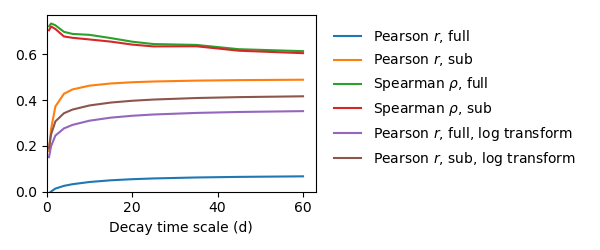

In [26]:
fig=plt.figure(figsize=(6,2.5))
plt.plot(df_skill['tau_d'],df_skill['r'],label='Pearson $r$, full')
plt.plot(df_skill['tau_d'],df_skill['r_sub'],label='Pearson $r$, sub')

plt.plot(df_skill['tau_d'],df_skill['rho'],label=r'Spearman $\rho$, full')
plt.plot(df_skill['tau_d'],df_skill['rho_sub'],label=r'Spearman $\rho$, sub')

plt.plot(df_skill['tau_d'],df_skill['rlog'],label='Pearson $r$, full, log transform')
plt.plot(df_skill['tau_d'],df_skill['rlog_sub'],label='Pearson $r$, sub, log transform')
plt.legend(loc='upper left',bbox_to_anchor=[1.02,1.0],frameon=False)
plt.xlabel('Decay time scale (d)')
plt.axis(ymin=0,xmin=0)
fig.tight_layout()

In [ ]:
skills=[]
tau_d=40

for storm_factor in [0.005,0.01,0.02,0.03,0.04,0.05,0.08,0.1,0.15,0.2,0.3,0.4,0.5,0.75,1]:
    tau=np.timedelta64(int(tau_d*86400),'s')
    manta_pred=predict_mantas(manta,tau,storm_factor=storm_factor)

    skill=dict(tau_d=tau_d,storm_factor=storm_factor)
    
    obs=manta_pred['part_per_m2_nofiber']
    mod=manta_pred['C_model'] 

    r=np.corrcoef(obs, mod)[0,1]
    rho,p=spearmanr(obs, mod)
    rlog=np.corrcoef( np.log(obs[obs>0]),mod[obs>0])[0,1]
    skill['r']=r
    skill['rho']=rho
    skill['rho_p']=p
    skill['rlog']=rlog
    
    # Same but drop top/bottom 2 outliers:
    obs_rank=np.argsort(np.argsort(obs))
    sel=(obs_rank>2)&(obs_rank<len(obs)-2)
    r=np.corrcoef(obs[sel], mod[sel])[0,1]
    rho,p=spearmanr(obs[sel], mod[sel])
    rlog=np.corrcoef( np.log(obs[sel]),mod[sel])[0,1]
    skill['r_sub']=r
    skill['rho_sub']=rho
    skill['rho_p_sub']=p
    skill['rlog_sub']=rlog
    
    skills.append(skill)
    
df_skill_sf=pd.DataFrame(skills)


In [ ]:
fig=plt.figure(figsize=(6,2.5))
#x=df_skill['tau_d']
#plt.xlabel('Decay time scale (d)')
x=np.log(df_skill_sf['storm_factor'])
plt.xlabel('log(Storm factor)')
plt.plot(x,df_skill_sf['r'],label='Pearson $r$, full')
plt.plot(x,df_skill_sf['r_sub'],label='Pearson $r$, sub')

plt.plot(x,df_skill_sf['rho'],label=r'Spearman $\rho$, full')
plt.plot(x,df_skill_sf['rho_sub'],label=r'Spearman $\rho$, sub')

plt.plot(x,df_skill_sf['rlog'],label='Pearson $r$, full, log transform')
plt.plot(x,df_skill_sf['rlog_sub'],label='Pearson $r$, sub, log transform')
plt.legend(loc='upper left',bbox_to_anchor=[1.02,1.0],frameon=False)
plt.axis(ymin=0) # ,xmin=0)
fig.tight_layout()


In [ ]:
pred_tau1=predict_mantas(manta,np.timedelta64(1,'D'))
pred_tau60=predict_mantas(manta,np.timedelta64(60,'D'))


In [ ]:
fig,axss=plt.subplots(2,2)

for axs,marker,tau_d,pred in [(axss[0,:],'o',1,pred_tau1),
                              (axss[1,:],'P',60,pred_tau60) ]:
    obs=pred['part_per_m2_nofiber']
    mod=pred['C_model'] 
    val=np.arange(len(obs))
    
    axs[0].scatter(obs,mod,30,val,cmap='jet',marker=marker,
                   label=f"{tau_d} days")
    obs_rank=np.argsort(np.argsort(obs))
    mod_rank=np.argsort(np.argsort(mod))
    axs[1].scatter(obs_rank,mod_rank,30,val,cmap='jet',marker=marker,
                   label=f"{tau_d} days")
    


Previously I got these results:
* Pearson $r$ is maximized by omitting any decay, as in $\tau\rightarrow\infty$
* Spearman $\rho$ is maximized by having a very short decay, 15h
* Log-transformed Pearson $r$ is maximized at around 25 days.

If I remove the top 2 and bottom 2 observed values, then Pearson
values come up to a level similar to log-pearson. Pearson
is still maximized by having little or no decay.

Re-running this, I don't see the local max in Pearson of the
log-transformed data.

What does it mean that Pearson correlation is highest at long decay
time scales, while Spearman is highest at short decay scales?

At short decay time scales, many of the predicted concentrations end up being
very small, substantially smaller than the observations even with no scaling
of the loads. This is penalized by Pearson, but for Spearman this correlates with
the lower concentration in the ocean compared to the estuary, and thus increases
skill.


In [ ]:
# What is Spearman just for getting two populations split correctly?
# Similar to what I get (for an offset that nearly makes the populations
# distinct)
# If the populations are different by a scale, then it takes a pretty 
# large scale (30?) to get a spearman of 0.7.

N=60
obs=np.random.random(N)
mod=np.random.random(N)

#off=0.8
#obs[:N//2]+=off
#mod[:N//2]+=off

fac=30
obs[:N//2]*=fac
mod[:N//2]*=fac

rho,p=spearmanr(obs,mod)
rho

In [ ]:
# Group samples - Central Bay, North Bay, South Bay, NMS.
def loc_to_region(s):
    if s.startswith('SPB') or s.startswith('SUB'): return 'NB'
    if s.startswith('SB') or s.startswith('LSB'): return 'SB'
    if s.startswith('GFNMS') or s.startswith('MBNMS') or s.startswith('CBNMS'): 
        return 'NMS'
    if s.startswith('CB') or s=='SFBay': return 'CB'
    raise Exception("No match for %s"%s)
    
def analyze_medians(df):
    dfm=df.loc[:,['region','obs','predicted']].melt(id_vars=['region']).set_index(['region','variable'])

    dfm.sort_index(inplace=True)

    def p_total(f):
        # Maximize the combined median test
        p_tot=1.0
        for region in ['CB','NB','SB','NMS']:
            obs=dfm.loc[ (region,'obs'), 'value']
            mod=f*dfm.loc[ (region,'predicted'), 'value']
            # is it better to choose just the modeled data where the observation
            # is valid?
            stat,p,M,cont=stats.median_test( obs[np.isfinite(obs)] ,
                                             mod[np.isfinite(mod)] )
            p_tot*=p
        return p_tot

    def cost(p):
        return -p_total( 10**p )

    from scipy.optimize import brute

    best=brute(cost,[[-4,1]],Ns=51)
    scale=10**best[0]
    p_tot=p_total(scale)
    print(f"P-total: {p_tot:.3f}  with scale: {1/scale:5f}")
    return p_tot,scale

In [ ]:
# Pulling in the old code from median comparisons.

manta_field='part_per_m2_nofiber'

for tau_d in [50]: # [0.5,1,1.5,2.,3,4,5,6,8,10,12,15,20,25,30,35,40,45,50,55,60]:
    print(f"Tau: {tau_d} days")
    tau=np.timedelta64(int(tau_d*86400),'s')
    df=predict_mantas(manta,tau,storm_factor=0.01)
    
    df=df[ df[manta_field].notnull() ].copy()
    
    regions=df['region']=df['SAMPLE LOCATION'].apply(loc_to_region)
    df=df.rename(columns={manta_field:'obs','C_model':'predicted'}).loc[:,['region','obs','predicted']]

    # Scale gets optimized to find the best nonparametric match
    p_tot,scale=analyze_medians(df)

    # This is not rigorous!
    obs_mag=1.0
    pred_mag=1/scale
    
    df['obs_frac']=df['obs'] / obs_mag
    df['pred_frac']=df['predicted'] / pred_mag

    dfm=df.loc[:,['region','obs_frac','pred_frac']].melt(id_vars=['region'])

    fig,ax=plt.subplots(1,1)# ,figsize=(10,3))
    sns.boxplot(x='region',y='value',hue='variable',data=dfm,fliersize=0,whis=0,
                ax=ax,bootstrap=1000)
    ax.axis(ymax=0.35,ymin=0)
    ax.legend(ax.artists,['Observed',f'Predicted/{pred_mag:.2f}'],loc='upper right')
    ax.set_ylabel('Particle m$^{-2}$')
    ax.set_xlabel('Region')
    
    ax.set_title(f'Tau={tau_d} days  $\\Pi \\rho$={p_tot:.2f}')
    df2=dfm.set_index(['region','variable'])
    p_tot=1.0
    for region in ['CB','NB','SB','NMS']:
        stat,p,M,cont=stats.median_test( df2.loc[ (region,'obs_frac'), 'value'] ,
                                         df2.loc[ (region,'pred_frac'), 'value'] )
        p_tot*=p
    print(f"{tau_d} days: ampl. error: {pred_mag/obs_mag:.3f} Median test net p: {p_tot:.5f}")
    
    print()
    fig.savefig(f'manta_comp_v05-tau{tau_d:.1f}.png',dpi=200)
    #break

In [ ]:
#plt.figure()
#plt.plot( df2.loc[('NB','obs_frac'),'value'], 'ro')
#plt.plot( df2.loc[('NB','pred_frac'),'value'],'go')

# Just 6 values...
display(df2.loc[('NB','obs_frac'),'value'])
display(df2.loc[('NB','pred_frac'),'value'])


In [ ]:
# For each manta sample, make a plot showing the conc. distribution at that time
# to debug what's up with the north bay samples:

tau_d=8
fac=39.81 # this is from analyze_medians.
six.moves.reload_module(conc_figure)

fig_dir=f"sample_wise_tau{tau_d}"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

tau=np.timedelta64(int(tau_d*86400),'s')
for idx,rec in manta.iterrows():
    print(idx)
    img_fn=os.path.join(fig_dir,f"sample-{idx}.png")
    fig,axs=plt.subplots(1,2,figsize=(11,7))
    fig.subplots_adjust(left=0,right=1,top=1,bottom=0,wspace=0.02)
    df=particles_for_date(rec.DATE).copy()

    age=df['time'] - df['rel_time']
    decay=np.exp( -age/tau ) 
    
    # No spatial weighting, but need the godin filter weights
    t_sample=np.datetime64(rec.DATE)
    # Noon, local, day of sampling
    t_center = t_sample+np.timedelta64(8,'h') + np.timedelta64(12,'h')
    delta_hours=((df['time']-t_center)/np.timedelta64(1,'h')).astype(np.int32)
    weight_time=godwin[delta_hours+godwin_offset_h]

    df['count']=weight_time * decay * df['mp_per_particle'] 

    weight=weight_time * decay * df['mp_per_particle'] 
        
    ds_conc=post.particles_to_conc(df,grid,'count')

    ds_smooth=ds_conc.copy()
    for _ in range(30):
        ds_smooth['conc']=('cell',), Msmooth.dot(ds_smooth.conc.values)
    
    cell=grid.select_cells_nearest([rec.x,rec.y])
        
    zoom=conc_figure.BayConcFigure.zoom
    
    if ( (rec.x>zoom[0]) and
        (rec.x<zoom[1]) and
        (rec.y>zoom[2]) and
        (rec.y<zoom[3])):
        FigCls=conc_figure.BayConcFigure
        FigCls.cax_loc=[0.82,0.25,0.03,0.35] # normalized to axis 
    else:
        FigCls=conc_figure.CoastalConcFigure
        
    for ds,ax in zip([ds_smooth,ds_conc],axs):
        cf=FigCls(ds,fig=fig,ax=ax,grid=grid)
        cf.ax.plot([rec.x],[rec.y],'k+')
        conc_pred=ds.conc.isel(cell=cell).item()
        conc_pred=conc_pred / fac

        cf.ax.text(rec.x,rec.y,
                   f"part_per_m2_nofiber\n obs={rec.part_per_m2_nofiber:.2e}\npred={conc_pred:.2e}")

        cf.ax.text(0.01,0.95,f"Manta sample: {rec.SampleID}",transform=cf.ax.transAxes,va='top')
    fig.savefig(img_fn,dpi=200)


In [ ]:
ds_conc

Next Steps
-- 

2. Think through how to present the comparisons. *ish*
3. What can we infer from these patterns? *ish*
4. Results appear worse, in terms of likelihood, than 
   for the old runs, probably driven by NB. Looks like 
   I am underpredicting NB.  Sample by sample, not terribly
   obvious what's up.  It's just 6 samples.
4. Would having different loss coefficients for WW and SW be worth
   attempting?
    - This is worth trying, and try maximizing the pearson with outliers
      tossed.
    - Does not make much difference.
5. Is it worth following a similar analysis to previously, lumping
   samples into embayments? *Blindly running that same code, it suggests
   that decay times >=20 days are best, with little difference beyond there.*
   I'm getting smaller net prob. values, though, and it seems to be driven
   by NB being underpredicted (relatively speaking) in the new runs. Any chance
   I'm missing something in the north? The one map plot above looks okay, but compare
   for wet weather.
   
What about applying a much more aggressive smoothing, going implicit?

In [ ]:
six.moves.reload_module(conc_figure)

conc_figure.BayConcFigure(conc_ds,grid=grid,cmap=cmap)